# Vector Transformations

Focus on vector transformations. Geometric dilation/contraction, convex hull, shape simplification, and vector conversions

In [2]:
# loading libraries

# Load relevant R packages
inLibraries = list('repr','rgdal','rgeos')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

Warning message:
"package 'rgdal' was built under R version 3.4.2"Warning message:
"package 'sp' was built under R version 3.4.2"Warning message:
"package 'rgeos' was built under R version 3.4.2"

## Vector Transformations (points, lines, polygons)

There are a variety of vector transformations supported by functions in R. Let's explore a few of these using the Puerto Rico .shp file (puertorico/PuertoRicoUTM.shp) which is a set of polygons representing adminstrative areas in the territory.  First, read the shp file and then display the polygons on the screen.

In [3]:
ppolys <- readOGR("datasets/puertorico", "PuertoRicoUTM")

OGR data source with driver: ESRI Shapefile 
Source: "datasets/puertorico", layer: "PuertoRicoUTM"
with 73 features
It has 10 fields
Integer64 fields read as strings:  ID cuerdas_07 cuerdas_02 


In [4]:
names(ppolys)

[1] "MUNICIPALI" "NUM"        "ADM"        "ID"         "nofarms_07"
 [6] "nofarms_02" "cuerdas_07" "cuerdas_02" "area"       "popden"

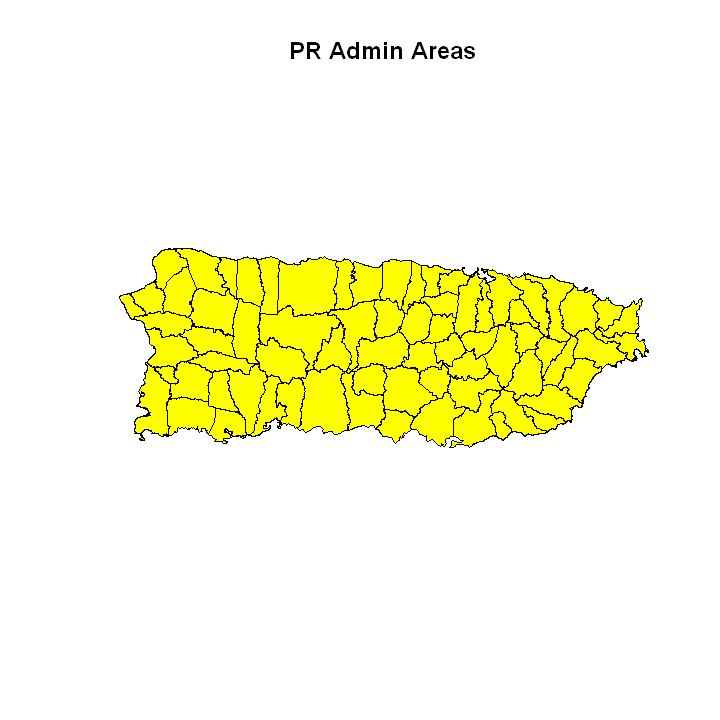

In [5]:
plot(ppolys, col = "yellow", main = "PR Admin Areas")

## Geometric dilation/contraction - aka Buffering

Whether working with points, line or polygons, one common transformation involves moving from one geometry to another. For example, a point can be transformed into a polygon by adding some radius to it; a line can be transformed to a polygon by adding width to it; a polygon can be transformed into a smaller polygon, line(s), or points by subtracting width from it. The general process at work here is geometric dialation and contraction.

To examine these notions, let's select one of the administrative areas in Puerto Rico, that of Coamo.

In [7]:
names(ppolys@data)

[1] "MUNICIPALI" "NUM"        "ADM"        "ID"         "nofarms_07"
 [6] "nofarms_02" "cuerdas_07" "cuerdas_02" "area"       "popden"

In [8]:
ppolys@data$MUNICIPALI

[1] ISABELA          AGUADILLA        HATILLO          CAMUY           
 [5] VEGA-BAJA        QUEBRADILLAS     VEGA-ALTA        DORADO          
 [9] MOCA             CAROLINA         RIO-GRANDE       TOA-ALTA        
[13] SAN-SEBASTIAN    LUQUILLO         TRUJILLO-ALTO    MOROVIS         
[17] COROZAL          LARES            NARANJITO        ANASCO          
[21] GURABO           AGUAS-BUENAS     JAYUYA           LAS-MARIAS      
[25] COMERIO          MAYAGUEZ         ADJUNTAS         MARICAO         
[29] AIBONITO         VILLALBA         SAN-GERMAN       PONCE           
[33] CABO-ROJO        HORMIGUEROS      SABANA-GRANDE    LAJAS           
[37] TOA-BAJA         ARECIBO          MANATI           SAN-JUAN/RIO-PIE
[41] GUAYNABO         AGUADA           RINCON           CIALES          
[45] UTUADO           CAGUAS           NAGUABO          CIDRA           
[49] SAN-LORENZO      CAYEY            JUANA-DIAZ       GUANICA         
[53] OROCOVIS         LAS-PIEDRAS      JUNCOS           BARRANQUITAS    
[57] HUMACAO          COAMO            GUAYANILLA       PENUELAS        
[61] YABUCOA          MAUNABO          YAUCO            PATILLAS        
[65] GUAYAMA          ARROYO           FAJARDO          CEIBA           
[69] SALINAS          SANTA-ISABEL     BARCELONETA/FLOR BAYAMON/CATANO  
[73] LOIZA/CANOVANAS 
73 Levels: ADJUNTAS AGUADA AGUADILLA AGUAS-BUENAS AIBONITO ANASCO ... YAUCO

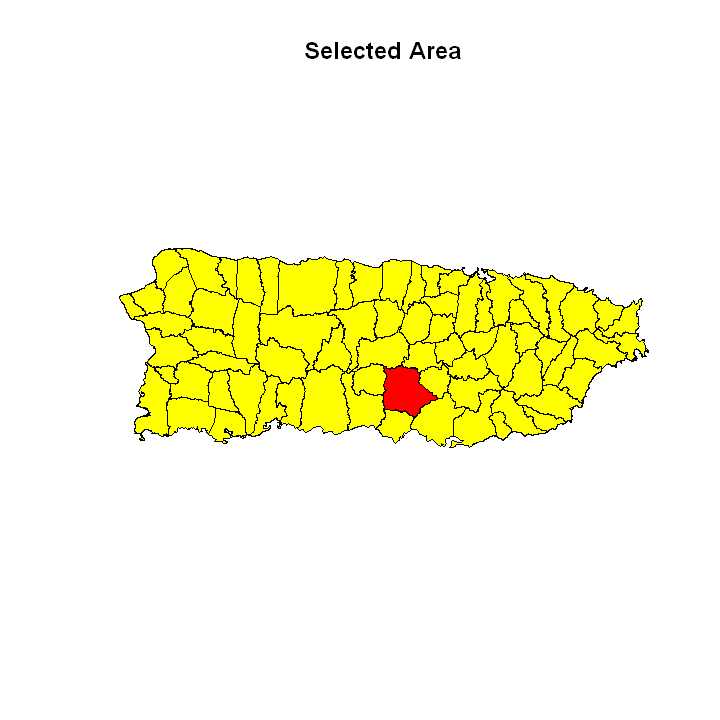

In [9]:
# selecting a feature to examine
FeatA <- ppolys[ppolys@data$MUNICIPALI == "COAMO", ]

plot(ppolys, col = "yellow", main = "Selected Area")
plot(FeatA, col = "red", add = TRUE)

### Dilation

Dilation (positive buffering) involves adding space to a feature. 

If one wished to get an idea about which other municipalities are within a certain distance of Coamo, one approach could be to buffer the polygon by that distance. The gBuffer() function (rgeos library) can be used to accomplish this task. Investigate the various parameters that can be used to populate the gBuffer() function. The distance to which the polygon is buffered in this case is controlled by the 'width' parameter. In the function below, 'FeatA' refers to the geometry to be buffered. While only one feature is selected to buffer in this case, gBuffer() can also process a set of features at the same time.

It is important to note that making complex distance calculations requires the dataset be properly projected into a relevant coordinate system. In this case, the data is projected in UTM zone 20N where the linear unit of measurement is 'meters'. Why is this important? How else would you know what measurement units to enter for the 'width' parameter?

In [10]:
# compute the geometrix dilation of the selected feature

FeatA.buf <- gBuffer(FeatA, 
                        byid = TRUE,
                        id = NULL,
                        width = 10000, 
                        quadsegs = 5,
                        capStyle = "ROUND",
                        joinStyle = "ROUND", 
                        mitreLimit = 1.0)

FeatA.buf@data

,MUNICIPALI,NUM,ADM,ID,nofarms_07,nofarms_02,cuerdas_07,cuerdas_02,area,popden
57,COAMO,20,4,58,335,351,16768,18549,77.44,239.5274


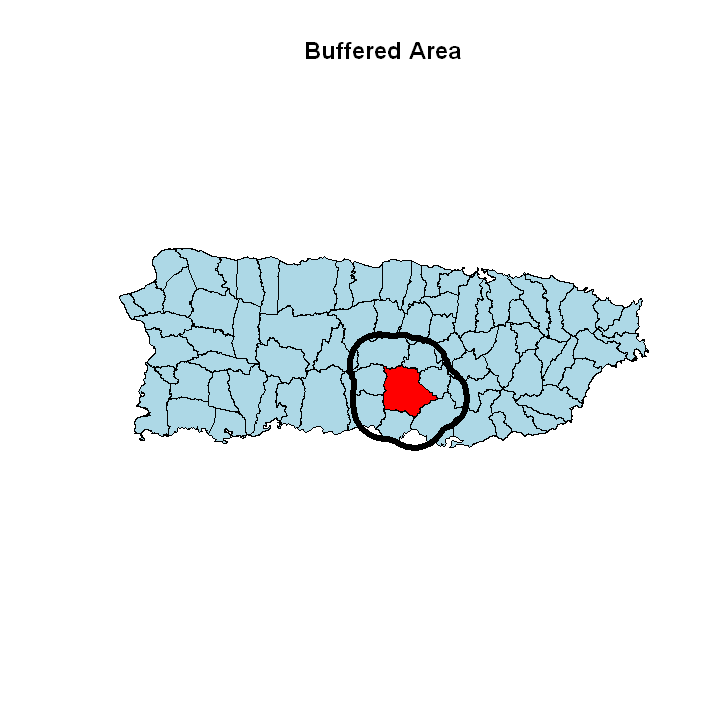

In [14]:
plot(ppolys, col = "lightblue", lwd = 0.2, main = "Buffered Area")
plot(FeatA, add = TRUE, col = "red", lwd = 0.2)
plot(FeatA.buf, add = TRUE, lwd = 5)

Thus, buffering the municipality by a positive amount creates a larger polygon. The gArea() function (rgeos library) can be used to query the area of the original and buffer polygons and evalute the difference in areas.  Remember, the distance units associated with the coordinate system of this dataset are in meters.  As such, the areas reported below are in what units??

In [15]:
# area of original municipality
featArea <- gArea(FeatA)
featArea

[1] 202528739

In [16]:
# area of the buffer
bufArea <- gArea(FeatA.buf)
bufArea

[1] 1148420690

In [17]:
# difference in the areas of the 2 polygons
diffArea <- bufArea - featArea
diffArea

[1] 945891951

### Contraction

Features can also be buffered by negative distances - i.e. contraction. Here, a negative buffer of -5000m is first applied followed by one of -6000m. If we were to continue decreasing the buffer, at some point the polygon would be reduced to a point.

In [26]:
# compute the geometric contraction of the selected feature
# buffer by -5000 meters
FeatA.neg5kbuf <- gBuffer(FeatA, byid = TRUE, id = NULL, width = -5000,
                              quadsegs = 5, capStyle = "ROUND", joinStyle = "ROUND", mitreLimit = 1.0)

In [27]:
# buffer by -8000 meters
FeatA.neg3kbuf <- gBuffer(FeatA, byid = TRUE, id = NULL, width = -3000,
                             quadsegs = 5, capStyle = "ROUND", joinStyle = "ROUND", mitreLimit = 1.0)

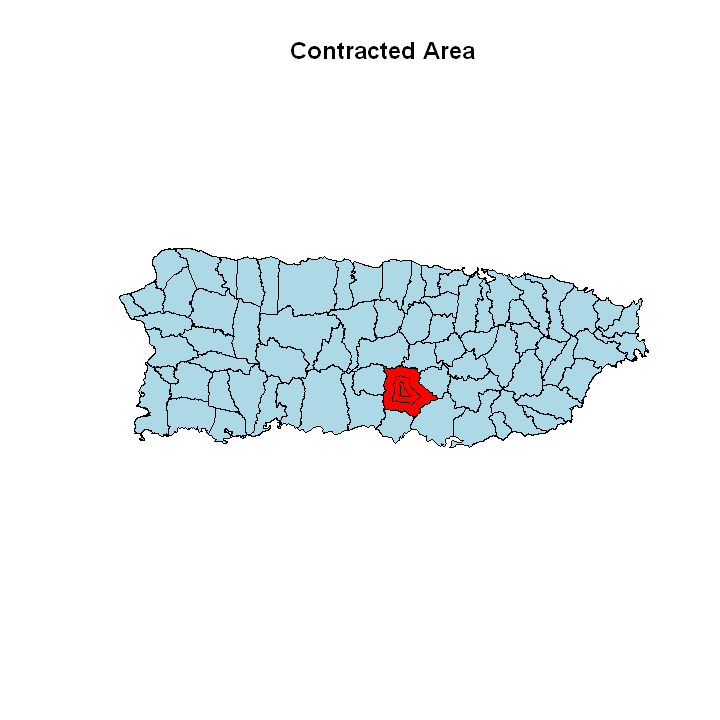

In [28]:
# display

plot(ppolys, col = "lightblue", lwd = 0.2, main = "Contracted Area")
plot(FeatA, add = TRUE, col = "red", lwd = 0.2)
plot(FeatA.neg5kbuf, add = TRUE, lwd = 1)
plot(FeatA.neg3kbuf, add = TRUE, lwd = 1)

## Convex Hull

Features can be transformed in a variety of other ways. For example, the smallest convex shape that can bound a feature (the convex hull) can be found using the gConvexHull() function (rgeos library). A convex geometry is one that could support direct movement between any pair of points in the polygon without having to exit the shape. Here, the original polygon is very non-convex. Its convex hull is the convex polygon of minimum size that can contain the original polygon. Why consider a feature's convex hull? Answer - A convex object is much more mathematically and computationally convienent to deal with than a non-convex object.

In [29]:
# compute the convex hull
FeatA.hull <- gConvexHull(FeatA)

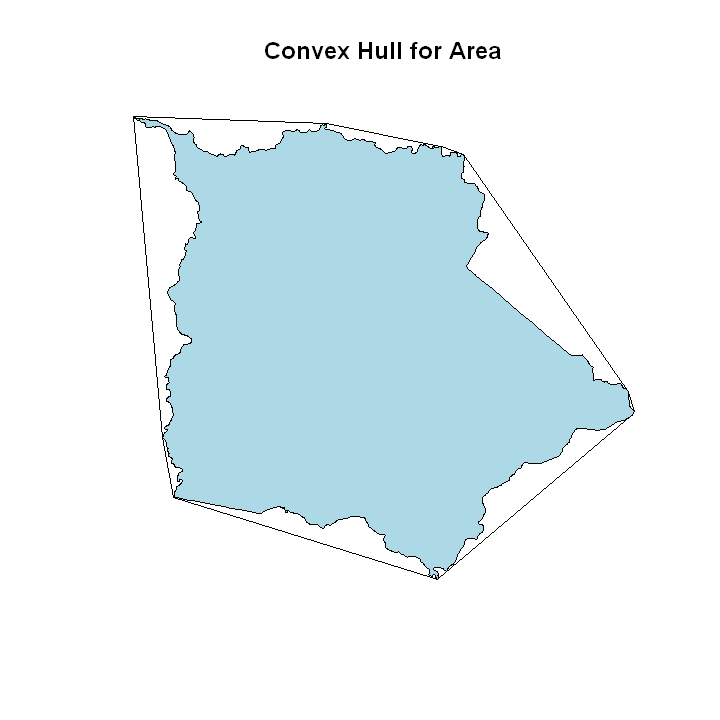

In [30]:
# plot
plot(FeatA, col = "lightblue", main = "Convex Hull for Area")
plot(FeatA.hull, add = TRUE)

## Shape Simplification

While a convex hull is a very dramatic generalization of a non-convex polygon, sometimes more subtle simplifications are warranted.  For example, a feature such as a line or polygon can be simplified by reducing the number of vertices involved using an algorithm such as the Douglas-Peuker algorithm. The gSimplify() function (rgeos library) can accomplish this task. The 'tol' parameter controls the tolerance of the simplification algorithm and is specified in the same units as the coordinate system (i.e. meters). Experiment with different 'tol' values and observe what happens. Note, the topologyPreserve parameter when set to 'TRUE' forces the topological ordering of vertices to be preserved in the output. 

In [31]:
# simplify the polygon geometry
simpFeatA <- gSimplify(FeatA, tol = 290, topologyPreserve = TRUE)

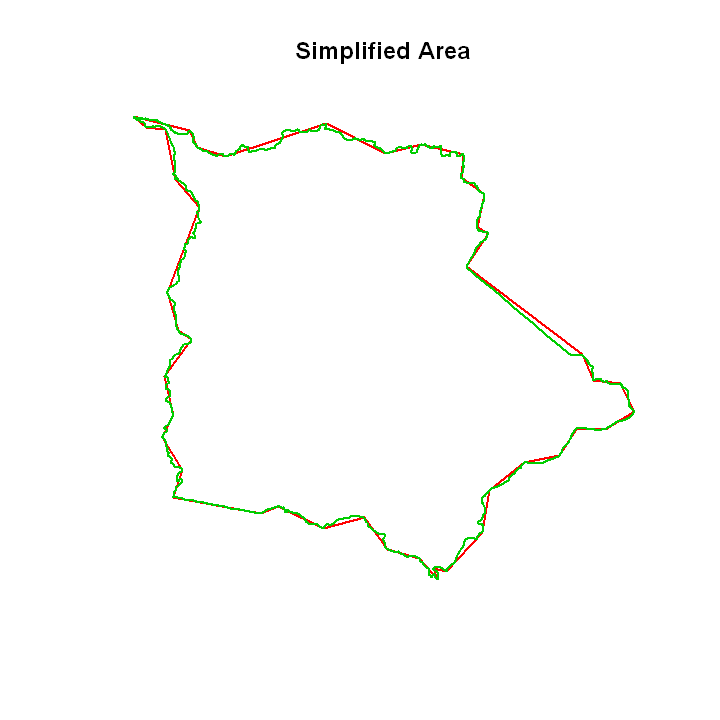

In [35]:
plot(simpFeatA, lwd = 2, border = "red", main = "Simplified Area")
plot(FeatA, add = TRUE, lwd = 2, border = 427)

## Moving From One Vector Geometry to Another

Remember, lines are comprised of points and polygons are comprised of lines.  As such, we can easily convert polygons to lines and the resulting lines to points. One way of doing this is by moving from one spatial dataframe type to another using the functionalities of the sp library.

In [36]:
# convert spatialpolygondataframe to spatiallinesdataframe
lineFeatA <- as(FeatA, "SpatialLinesDataFrame")

In [37]:
# convert spatiallinesdataframe to spatialpointsdataframe
ptFeatA <- as(lineFeatA, "SpatialPointsDataFrame")

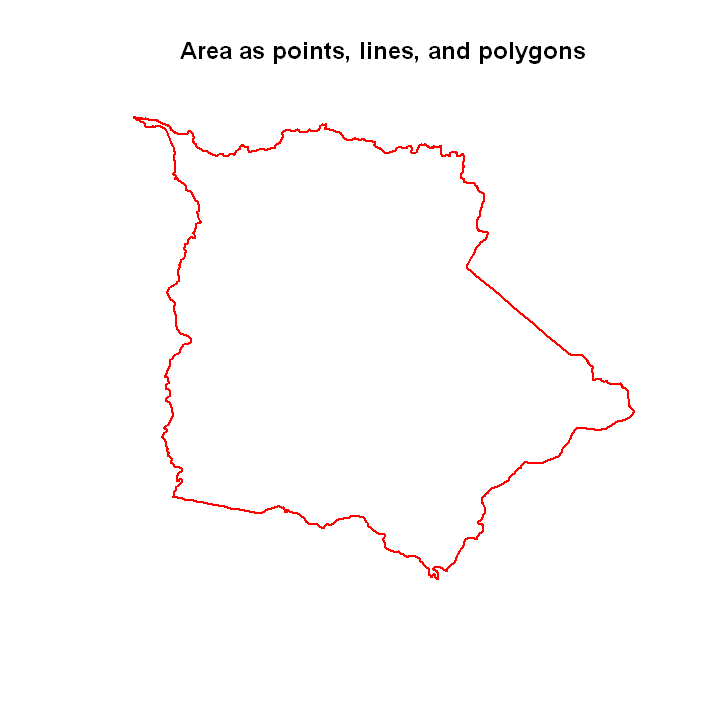

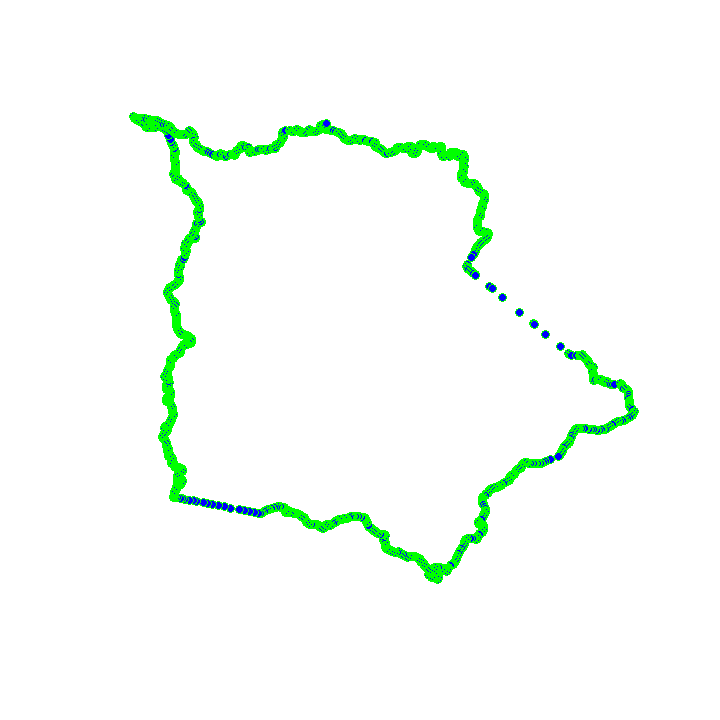

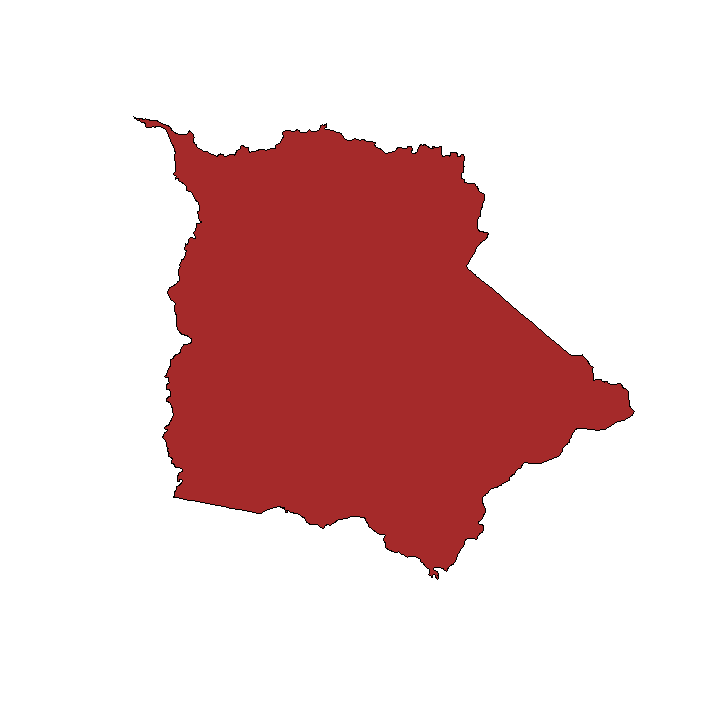

In [54]:
plot(lineFeatA, lwd = 2, col = "red", main = "Area as points, lines, and polygons")
plot(ptFeatA, add = FALSE, pch = 21, bg = "blue", col = "green", lwd = 0.1)
plot(FeatA, add = FALSE, col = "brown")